In [37]:
import pandas as pd
import os
import requests
import matplotlib as mpl
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import rasterio
from rasterio.windows import from_bounds
import shutil
from tqdm import tqdm
import re
import numpy as np

mpl.style.use("ggplot")

### Load climate data from [CHELSA](https://chelsa-climate.org/bioclim/)

In [2]:
with open("./envidatS3paths.txt", "r") as file:
    urls = file.readlines()

In [ ]:
if not os.path.exists("./climate_data/"):
    os.makedirs("./climate_data/")

for url in urls:
    url = url.strip()
    filename = os.path.join("./climate_data/", os.path.basename(url))
    if os.path.exists(filename):
        print(f"File {filename} already exists, skipping download.")
        continue
    print(f"Downloading {url} to {filename}")
    response = requests.get(url)
    if response.status_code == 200:
        with open(filename, "wb") as f:
            f.write(response.content)
        print(f"Downloaded {filename}")
    else:
        print(f"Failed to download {url}. Status: {response.status_code}")
# Takes 40 min

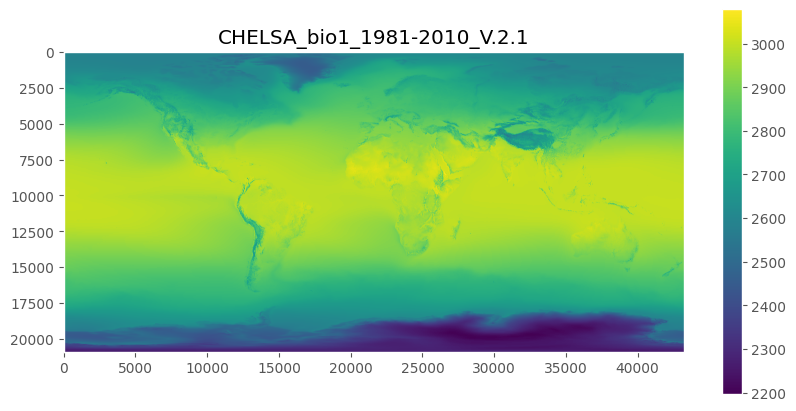

In [6]:
# Plot 1 for example
with rasterio.open("./climate_data/CHELSA_bio1_1981-2010_V.2.1.tif") as dataset:
    band1 = dataset.read(1)
    fig, ax = plt.subplots(figsize=(10, 10))
    img = ax.imshow(band1, cmap="viridis")
    cbar = plt.colorbar(img, ax=ax, shrink=0.5)
    ax.set_title("CHELSA_bio1_1981-2010_V.2.1")
    ax.grid(False)
    plt.show()

In [7]:
# Check that all geotiffs have 1 band
os.environ["GTIFF_SRS_SOURCE"] = "EPSG"


def check_bands_in_geotiffs(directory):
    results = []
    for filename in os.listdir(directory):
        if filename.endswith(".tif"):
            file_path = os.path.join(directory, filename)
            with rasterio.open(file_path) as dataset:
                band_count = dataset.count
                if band_count > 1:
                    results.append((filename, band_count))
                    print(f"{filename} = {band_count} band(s)")
    return results


results = check_bands_in_geotiffs("./climate_data")

### Open geotiffs to smaller extent

In [9]:
# Bounds of global geotiff
with rasterio.open("./climate_data/CHELSA_bio1_1981-2010_V.2.1.tif") as dataset:
    print("Dataset bounds:", dataset.bounds)
    print("Dataset CRS:", dataset.crs)

Dataset bounds: BoundingBox(left=-180.00013888885002, bottom=-90.00013888884999, right=179.99985967115003, top=83.99986041515001)
Dataset CRS: EPSG:4326


In [10]:
# Define smaller extent
california_extent = [-125, -113, 32, 43]

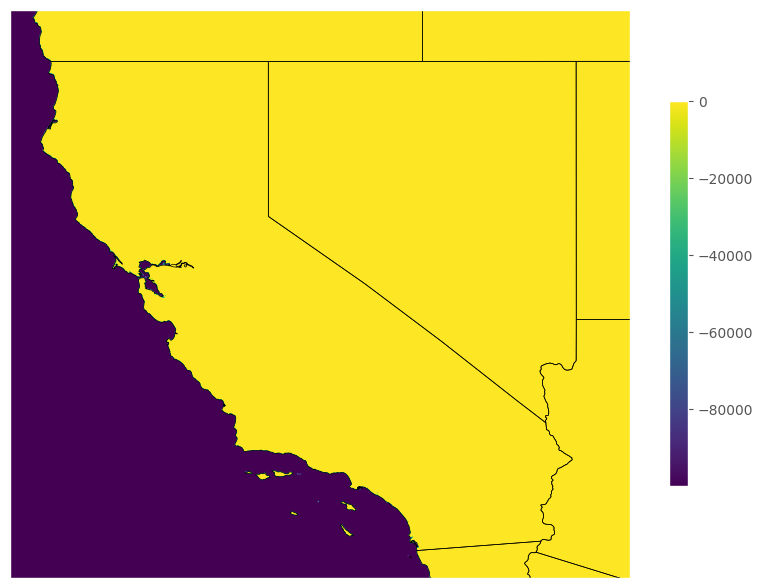

In [11]:
# Open geotiff and plot CA extent
with rasterio.open("./climate_data/CHELSA_ai_1981-2010_V.2.1.tif") as dataset:

    # create window for California extent
    transform = dataset.transform
    window = from_bounds(
        california_extent[0],  # left
        california_extent[2],  # bottom
        california_extent[1],  # right
        california_extent[3],  # top
        transform=transform,
    )
    band1 = dataset.read(1, window=window)
    img_extent = (
        california_extent[0],  # left
        california_extent[1],  # right
        california_extent[2],  # bottom
        california_extent[3],  # top
    )

    # Plot
    fig, ax = plt.subplots(
        figsize=(10, 10), subplot_kw={"projection": ccrs.PlateCarree()}
    )
    img = ax.imshow(band1, cmap="viridis", extent=img_extent, origin="upper")
    ax.add_feature(cfeature.STATES.with_scale("10m"))
    cbar = plt.colorbar(img, ax=ax, shrink=0.5)
    ax.grid(False)
    plt.show()

### Load kikuyugrass observations

In [14]:
data = pd.read_csv("./inaturalist_observations_cleaned.csv")
data[["lat", "long"]] = data["location"].str.split(",", expand=True)
data["lat"] = data["lat"].astype(float)
data["long"] = data["long"].astype(float)

In [26]:
location_data = data[["lat", "long", "uuid", "label"]]
location_data = pd.DataFrame(location_data)
location_data.head()

,lat,long,uuid,label
0,34.041287,-118.532091,cf6f9a84-0996-4ded-b2e0-a7bd12d67217,kikuyugrass
1,32.658961,-117.060481,39f544ee-5509-49ea-a296-19c825217ee1,kikuyugrass
2,35.322144,-120.823204,28751c0a-3cd3-4f64-9058-75e564f328f8,kikuyugrass
3,37.831630,-122.534875,03159809-00bc-4852-bbd6-2aab8038a6ba,kikuyugrass
4,32.737291,-117.126908,192ed8dc-5066-42cb-b58f-8cf69f070b2a,kikuyugrass


### Load background points

In [27]:
background = pd.read_csv("./background_data_coords.csv")
background.head()

,id,label,lat,long
0,0,background,34.429027,-119.895972
1,1,background,34.154027,-115.845972
2,2,background,36.604027,-121.845972
3,3,background,39.487361,-122.087639
4,4,background,34.612361,-119.670972


### Merge points into 1 dataframe

In [28]:
background = background.rename(columns={"id": "uuid"})
combined_data = pd.concat([location_data, background], ignore_index=True)
print(combined_data.head())
print(combined_data.tail())

         lat        long                                  uuid        label
0  34.041287 -118.532091  cf6f9a84-0996-4ded-b2e0-a7bd12d67217  kikuyugrass
1  32.658961 -117.060481  39f544ee-5509-49ea-a296-19c825217ee1  kikuyugrass
2  35.322144 -120.823204  28751c0a-3cd3-4f64-9058-75e564f328f8  kikuyugrass
3  37.831630 -122.534875  03159809-00bc-4852-bbd6-2aab8038a6ba  kikuyugrass
4  32.737291 -117.126908  192ed8dc-5066-42cb-b58f-8cf69f070b2a  kikuyugrass
             lat        long  uuid       label
10263  36.145694 -121.104306  9905  background
10264  40.695694 -122.020972  9906  background
10265  36.062361 -120.195972  9907  background
10266  36.854027 -117.704306  9908  background
10267  39.704027 -123.704306  9909  background


### Extract climate data at each observation

In [33]:
directory = "./climate_data"
california_extent  # (left, bottom, right, top)

[-125, -113, 32, 43]

In [ ]:
pattern = r"CHELSA_(.+)_1981-2010(?:_(\w+))?_V\.\d+\.\d+"
processed_columns = set()

points_in_bounds = (
    (combined_data["long"] >= california_extent[0])
    & (combined_data["long"] <= california_extent[1])
    & (combined_data["lat"] >= california_extent[2])
    & (combined_data["lat"] <= california_extent[3])
)

if not points_in_bounds.all():
    print(f"Warning: {(~points_in_bounds).sum()} points fall outside CONUS extent")
    # Optionally print the out-of-bounds points:
    print(combined_data[~points_in_bounds][["lat", "long"]])

# Iterate over files in the directory with tqdm progress bar
for filename in tqdm(os.listdir(directory), desc="Processing files", unit="file"):
    if filename.endswith(".tif"):
        match = re.search(pattern, filename)
        if match:
            variable_name = match.group(1)
            suffix = match.group(2)  # This will be None if there's no suffix
            if variable_name == "rsds" and suffix is None:
                continue
            column_name = f"{variable_name}_{suffix}" if suffix else variable_name
            if column_name in processed_columns:
                continue  # Skip if already processed
            processed_columns.add(column_name)

            # Full path to the file
            file_path = os.path.join(directory, filename)

            # Open the raster and limit to CONUS extent
            with rasterio.open(file_path) as dataset:
                raster_bounds = dataset.bounds
                print(f"\nRaster bounds for {filename}:")
                print(f"left: {raster_bounds.left}, right: {raster_bounds.right}")
                print(f"bottom: {raster_bounds.bottom}, top: {raster_bounds.top}")

                coords = [
                    (x, y) for x, y in zip(combined_data["long"], combined_data["lat"])
                ]

                # Sample raster at these points
                sampled_values = list(dataset.sample(coords))
                sampled_values = [value[0] for value in sampled_values]

                # Check for any null values in the sampling
                null_count = sum(1 for v in sampled_values if v is None or np.isnan(v))
                if null_count > 0:
                    print(f"Warning: {null_count} null values found in {filename}")

                combined_data[column_name] = sampled_values

for col in processed_columns:
    print(f"\nSummary for {col}:")
    print(combined_data[col].describe())

In [39]:
combined_data.head()

,lat,long,uuid,label,ai,bio10,bio11,bio12,bio13,bio14,...,sfcWind_max,sfcWind_mean,sfcWind_min,sfcWind_range,swb,swe,vpd_max,vpd_mean,vpd_min,vpd_range
0,34.041287,-118.532091,cf6f9a84-0996-4ded-b2e0-a7bd12d67217,kikuyugrass,0.331897,2950,2862,3857,966,6,...,2068,1885,1704,364,-980,65535,11198,8381,6363,4835
1,32.658961,-117.060481,39f544ee-5509-49ea-a296-19c825217ee1,kikuyugrass,0.286715,2938,2869,2806,571,14,...,1141,1067,986,155,-858,65535,9115,7671,6490,2625
2,35.322144,-120.823204,28751c0a-3cd3-4f64-9058-75e564f328f8,kikuyugrass,0.550209,2912,2851,5192,1067,7,...,2345,2029,1746,599,-756,65535,7355,6367,5158,2197
3,37.831630,-122.534875,03159809-00bc-4852-bbd6-2aab8038a6ba,kikuyugrass,-99999.000000,2887,2837,7961,1621,9,...,5654,4713,3940,1714,-645,65535,5763,5171,4497,1266
4,32.737291,-117.126908,192ed8dc-5066-42cb-b58f-8cf69f070b2a,kikuyugrass,0.278504,2939,2866,2782,568,11,...,1301,1210,1116,186,-891,65535,8773,7453,6349,2424


In [41]:
combined_data.columns

Index(['lat', 'long', 'uuid', 'label', 'ai', 'bio10', 'bio11', 'bio12',
       'bio13', 'bio14', 'bio15', 'bio16', 'bio17', 'bio18', 'bio19', 'bio1',
       'bio2', 'bio3', 'bio4', 'bio5', 'bio6', 'bio7', 'bio8', 'bio9',
       'clt_max', 'clt_mean', 'clt_min', 'clt_range', 'cmi_max', 'cmi_mean',
       'cmi_min', 'cmi_range', 'fcf', 'fgd', 'gdd0', 'gdd10', 'gdd5',
       'gddlgd0', 'gddlgd10', 'gddlgd5', 'gdgfgd0', 'gdgfgd10', 'gdgfgd5',
       'gsl', 'gsp', 'gst', 'hurs_max', 'hurs_mean', 'hurs_min', 'hurs_range',
       'kg0', 'kg1', 'kg2', 'kg3', 'kg4', 'kg5', 'lgd', 'ngd0', 'ngd10',
       'ngd5', 'npp', 'pet_penman_max', 'pet_penman_mean', 'pet_penman_min',
       'pet_penman_range', 'rsds_max', 'rsds_mean', 'rsds_min', 'rsds_range',
       'scd', 'sfcWind_max', 'sfcWind_mean', 'sfcWind_min', 'sfcWind_range',
       'swb', 'swe', 'vpd_max', 'vpd_mean', 'vpd_min', 'vpd_range'],
      dtype='object')

In [ ]:
# Points with ai -99999 are in the ocean
print(combined_data[combined_data["ai"] <= -99999].shape[0])

# Throw them out, although they may be ok
combined_data = combined_data[combined_data["ai"] > -99999]

42


### Save csv of climate data for each point

In [44]:
combined_data.to_csv("./location_climate_data.csv")

In [45]:
# Delete geotiffs because they are very large files
# if os.path.exists(directory):
#    shutil.rmtree(directory)